In [98]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import csv
import json
import pandas as pd
import math

## Measured job load

In [99]:
csvfile = open('../cirrus-cpu-simple-rigid/data/raw-job-data/raw_job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
measured_job_l = []
maxtime = 0
for row in csvreader:
    if int(row['End Time']) > maxtime:
        maxtime = int(row['End Time'])
    if row['Nodes'] is None:
        print(row)
    measured_job_l.append(row)

print(maxtime)

31778


In [100]:
measured_load_a = np.zeros(maxtime+1, dtype=int)
totuse = 0
for job in measured_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = int(job['Start Time'])
    iend = int(job['End Time'])
    nodes = int(job['Nodes'])
    totuse = totuse + int(job['Makespan'])
    temp_a[istart:iend] = nodes
    measured_load_a = measured_load_a + temp_a

print(totuse)

4075948


<Figure size 640x480 with 0 Axes>

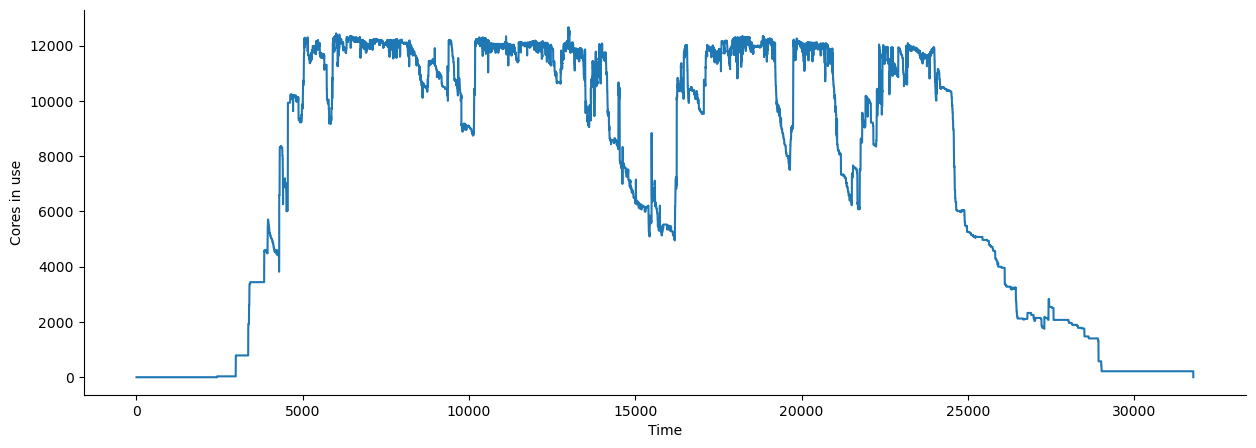

In [101]:
plt.clf()
plt.figure(figsize=(15, 5))
plt.plot(measured_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
plt.savefig("measured_load.png")

## Simulated job load (rigid)

In [102]:
csvfile = open('../cirrus-cpu-simple-rigid/data/output/job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
rigid_job_l = []
for row in csvreader:
    rigid_job_l.append(row)

print(rigid_job_l[0])
print(rigid_job_l[-1])


{'ID': '0', 'Type': 'rigid', 'Submit Time': '0', 'Start Time': '0', 'End Time': '1423', 'Wait Time': '0', 'Makespan': '1423', 'Turnaround Time': '1423', 'Status': 'completed'}
{'ID': '11634', 'Type': 'rigid', 'Submit Time': '23983', 'Start Time': '24141', 'End Time': '24231', 'Wait Time': '158', 'Makespan': '90', 'Turnaround Time': '248', 'Status': 'completed'}


In [103]:
jsonfile = open('../cirrus-cpu-simple-rigid/data/input/2024_Q1_CPU-jobs.json', 'r')
jobs_d = json.load(jsonfile)
i = 0
maxtime = 0
totuse = 0
for job in jobs_d['jobs']:
    rigid_job_l[i]['Nodes'] = int(job['num_nodes'])
    totuse = totuse + float(rigid_job_l[i]['Makespan'])
    if float(rigid_job_l[i]['End Time']) > maxtime:
        maxtime = math.ceil(float(rigid_job_l[i]['End Time']))
    i += 1

print(len(rigid_job_l))
print(maxtime)
print(totuse)

11635
31778
4075948.0


In [104]:
rigid_load_a = np.zeros(maxtime+1, dtype=int)

In [105]:
for job in rigid_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = math.floor(float(job['Start Time']))
    iend = math.ceil(float(job['End Time']))
    nodes = int(job['Nodes'])
    temp_a[istart:iend] = nodes
    rigid_load_a = rigid_load_a + temp_a

print(rigid_load_a)

[756 756 756 ... 216 216   0]


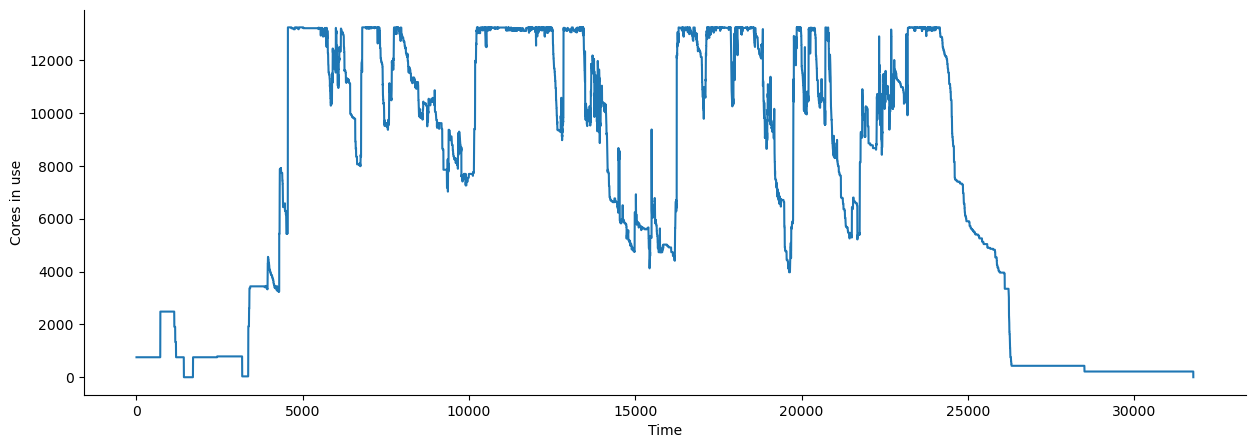

In [107]:
plt.figure(figsize=(15, 5))
plt.plot(rigid_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
plt.savefig("simulated_load_rigid.png")

## Moldable jobs

In [121]:
csvfile = open('../cirrus-cpu-simple-moldable/data/output/job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
moldable_job_l = []
for row in csvreader:
    moldable_job_l.append(row)

print(moldable_job_l[0])
print(moldable_job_l[-1])


{'ID': '0', 'Type': 'moldable', 'Submit Time': '0', 'Start Time': '0', 'End Time': '1423', 'Wait Time': '0', 'Makespan': '1423', 'Turnaround Time': '1423', 'Status': 'completed'}
{'ID': '11634', 'Type': 'moldable', 'Submit Time': '23983', 'Start Time': '24733', 'End Time': '24823', 'Wait Time': '750', 'Makespan': '90', 'Turnaround Time': '840', 'Status': 'completed'}


In [122]:
jsonfile = open('../cirrus-cpu-simple-moldable/data/input/2024_Q1_CPU-jobs_moldable.json', 'r')
jobs_d = json.load(jsonfile)
i = 0
maxtime = 0
totuse = 0
jobid_l = []
for job in jobs_d['jobs']:
    jobid_l.append(job['arguments']['jobid'])
    moldable_job_l[i]['BaseNodes'] = int(job['arguments']['base_nodes'])
    moldable_job_l[i]['MinNodes'] = int(job['num_nodes_min'])
    moldable_job_l[i]['MaxNodes'] = int(job['num_nodes_max'])
    i += 1


In [123]:
nodedata_df = pd.read_csv('../cirrus-cpu-simple-moldable/data/output/node_utilization.csv')
nodedata_df['Count'] = 1
nodedata_df.tail()

,Time,Node,State,Running jobs,Expected jobs,Count
1186156,31912,CCPU_11001,free,none,none,1
1186157,31912,CCPU_11002,free,none,none,1
1186158,31912,CCPU_11003,free,none,none,1
1186159,31912,CCPU_11004,free,none,none,1
1186160,31912,CCPU_11005,free,none,none,1


In [124]:
# nodecount_grouped = nodedata_df.groupby(by='Running jobs')['Count'].sum()
nodecount_grouped = nodedata_df.loc[nodedata_df['State'] == 'allocated'].groupby(by='Running jobs', sort=False)['Running jobs'].count()

In [125]:

for i, job in enumerate(moldable_job_l):
    cores = nodecount_grouped.iloc[i]
    moldable_job_l[i]['Nodes'] = cores
    totuse = totuse + float(moldable_job_l[i]['Makespan'])
    if float(moldable_job_l[i]['End Time']) > maxtime:
        maxtime = math.ceil(float(moldable_job_l[i]['End Time']))

moldable_job_df = pd.DataFrame(moldable_job_l)
print(moldable_job_df)

print(len(moldable_job_l))
print(maxtime)
print(totuse)

          ID      Type Submit Time Start Time End Time Wait Time Makespan  \
0          0  moldable           0          0     1423         0     1423   
1          1  moldable         715        715     1163         0      448   
2          2  moldable         715        715     1187         0      472   
3          3  moldable         715        715     1135         0      420   
4          4  moldable        1698       1698     3176         0     1478   
...      ...       ...         ...        ...      ...       ...      ...   
11630  11630  moldable       23977      24704    25533       727      829   
11631  11631  moldable       23980      24704    24733       724       29   
11632  11632  moldable       23983      24726    25752       743     1026   
11633  11633  moldable       23983      24733    25686       750      953   
11634  11634  moldable       23983      24733    24823       750       90   

      Turnaround Time     Status  BaseNodes  MinNodes  MaxNodes  Nodes  
0 

In [136]:
nrigid = len(moldable_job_df.loc[moldable_job_df['Nodes'] == moldable_job_df['BaseNodes']])
nmoldable = len(moldable_job_df.loc[moldable_job_df['Nodes'] != moldable_job_df['BaseNodes']])
nlarger = len(moldable_job_df.loc[moldable_job_df['Nodes'] > moldable_job_df['BaseNodes']])
nsmaller = len(moldable_job_df.loc[moldable_job_df['Nodes'] < moldable_job_df['BaseNodes']])
ntot = len(moldable_job_df)

print(f'Number of jobs at original size = {nrigid}/{ntot} ({100*nrigid/ntot:.2f}%)')
print(f'Number of jobs molded = {nmoldable}/{ntot} ({100*nmoldable/ntot:.2f}%)')
print(f'Number of jobs larger = {nlarger}/{ntot} ({100*nlarger/ntot:.2f}%)')
print(f'Number of jobs smaller = {nsmaller}/{ntot} ({100*nsmaller/ntot:.2f}%)')

Number of jobs at original size = 519/11635 (4.46%)
Number of jobs molded = 11116/11635 (95.54%)
Number of jobs larger = 9143/11635 (78.58%)
Number of jobs smaller = 1973/11635 (16.96%)


In [114]:
moldable_load_a = np.zeros(maxtime+1, dtype=int)
for job in moldable_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = math.floor(float(job['Start Time']))
    iend = math.ceil(float(job['End Time']))
    nodes = int(job['Nodes'])
    temp_a[istart:iend] = nodes
    moldable_load_a = moldable_load_a + temp_a


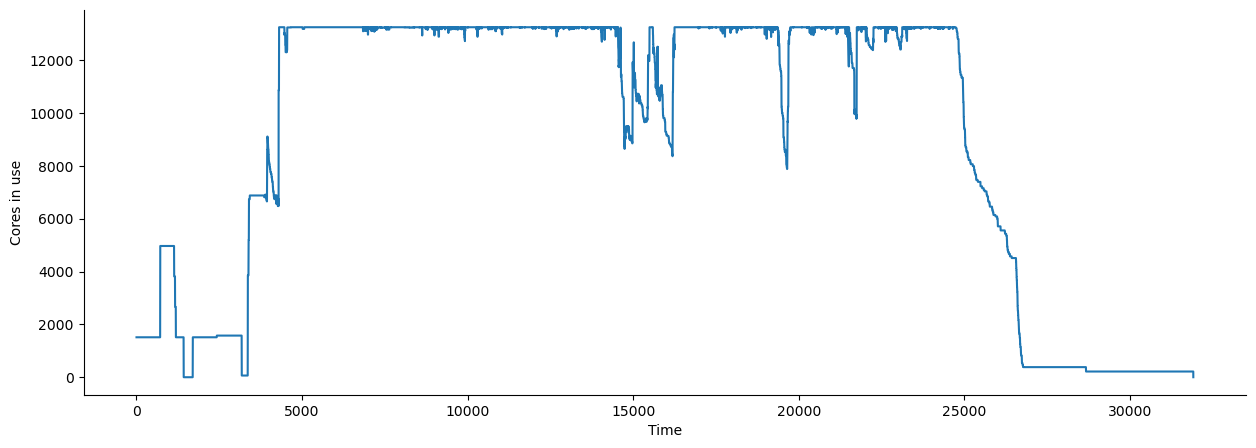

In [116]:
plt.figure(figsize=(15, 5))
plt.plot(moldable_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
plt.savefig("simulated_load_moldable.png")